In [3]:
import modin.pandas as mpd
#df = mpd.read_csv(r"2022_Yellow_Taxi_Trip_Data_20250414.csv")


In [ ]:
# Convert the DataFrame to Parquet format with gzip compression
#df.to_parquet("2022_Yellow_Taxi_Trip_Data_20250414.parquet", compression="gzip")



In [ ]:
df= mpd.read_parquet("2022_Yellow_Taxi_Trip_Data_20250414.parquet")


2025-04-25 20:08:22,754	INFO worker.py:1852 -- Started a local Ray instance.


(_remote_exec_multi_chain pid=56716) UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
(_remote_exec_multi_chain pid=636) UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
(_remote_exec_multi_chain pid=56592) UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format. [repeated 9x across cluster]
(_remote_exec_multi_chain pid=41628) UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
(_remote_exec_multi_chain pid=60520) UserWarning: Could not infer format, so each element

In [4]:
print(df.head())


   VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         1  01/01/2022 12:35:40 AM  01/01/2022 12:53:29 AM                2   
1         1  01/01/2022 12:33:43 AM  01/01/2022 12:42:07 AM                1   
2         2  01/01/2022 12:53:21 AM  01/01/2022 01:02:19 AM                1   
3         2  01/01/2022 12:25:21 AM  01/01/2022 12:35:23 AM                1   
4         2  01/01/2022 12:36:48 AM  01/01/2022 01:14:20 AM                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.80           1                  N           142           236   
1           2.10           1                  N           236            42   
2           0.97           1                  N           166           166   
3           1.09           1                  N           114            68   
4           4.30           1                  N            68           163   

   payment_type  fare_amount  extra  mta_tax

In [5]:
print(df.dtypes)

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
airport_fee              float64
dtype: object


In [6]:
# check how many values are missing in each column
print(df.isnull().sum())

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1368303
trip_distance                  0
RatecodeID               1368303
store_and_fwd_flag       1368303
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     1368303
airport_fee              1368303
dtype: int64


In [7]:
# check percentage of missing values in each column
print(df.isnull().sum() / len(df) * 100)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.450423
trip_distance            0.000000
RatecodeID               3.450423
store_and_fwd_flag       3.450423
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.450423
airport_fee              3.450423
dtype: float64


In [5]:
# convert the pickup and dropoff datetime columns to datetime objects
df['tpep_pickup_datetime'] = mpd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = mpd.to_datetime(df['tpep_dropoff_datetime'])
#df.dtypes

In [6]:
df_cleaned = df.copy()

In [7]:
df_cleaned = df_cleaned.drop(columns=['improvement_surcharge', 'store_and_fwd_flag'])

In [8]:
# how many rows are there in the sampled dataframe
print(len(df_cleaned))

39656098


In [8]:
missing_cols = ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'airport_fee']

# Create a boolean mask for rows where ALL 4 columns are NaN
all_missing_mask = df_cleaned[missing_cols].isnull().all(axis=1)

# Count how many rows this applies to
num_all_missing = all_missing_mask.sum()

print(f"Rows with all 4 values missing: {num_all_missing}")

Rows with all 4 values missing: 1368303


In [9]:
# Remove rows where ALL 4 columns are NaN
df_cleaned = df_cleaned[~all_missing_mask]


In [14]:
# get database statistics
df_cleaned.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,airport_fee
count,3.828780e+07,38287795,38287795,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07,3.828780e+07
mean,1.713156e+00,2022-07-05 00:02:30.606806528,2022-07-05 00:57:11.752203264,1.401149e+00,3.514399e+00,1.424172e+00,1.649293e+02,1.628563e+02,1.232061e+00,1.462763e+01,1.040985e+00,4.885367e-01,2.713900e+00,5.310589e-01,2.142373e+01,2.281437e+00,9.741937e-02
min,1.000000e+00,2001-01-01 00:03:14,2001-01-01 00:34:17,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.564000e+03,-2.218000e+01,-5.500000e-01,-4.100000e+02,-9.999000e+01,-2.567800e+03,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2022-04-07 19:04:36.500000,2022-04-07 19:21:25,1.000000e+00,1.100000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-01,7.000000e-01,0.000000e+00,1.230000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2022-06-30 23:33:04,2022-06-30 23:50:20,1.000000e+00,1.860000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+01,5.000000e-01,5.000000e-01,2.150000e+00,0.000000e+00,1.595000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2022-10-04 17:04:52.500000,2022-10-04 17:23:22,1.000000e+00,3.490000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.600000e+01,2.500000e+00,5.000000e-01,3.350000e+00,0.000000e+00,2.277000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,2023-04-18 14:30:05,2023-04-18 23:30:39,9.000000e+00,1.843408e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.010923e+05,3.350000e+01,2.548000e+01,1.400160e+03,9.118700e+02,4.010956e+05,2.750000e+00,1.250000e+00
std,4.522879e-01,NaN,NaN,9.628938e-01,5.643246e+01,5.794343e+00,6.494462e+01,7.015708e+01,4.760829e-01,9.743135e+01,1.271069e+00,9.508469e-02,3.288837e+00,2.031171e+00,9.801355e+01,7.519435e-01,3.385391e-01


In [15]:
# print rows where trip distance is greater than 100 miles
# and sort them in descending order, and decending by total_amount
df_cleaned[df_cleaned["trip_distance"] > 100].sort_values("trip_distance", ascending=False).head(10)



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,airport_fee
18946468,2,2022-06-24 08:24:35,2022-06-24 08:32:20,1.0,184340.80,5.0,113,107,2,38.08,0.0,0.5,0.00,0.00,41.38,2.5,0.0
26162251,2,2022-09-01 09:04:30,2022-09-01 09:15:17,1.0,164072.79,5.0,262,238,1,16.00,0.0,0.5,3.24,0.00,22.54,2.5,0.0
25049328,2,2022-08-21 19:12:22,2022-08-21 19:21:02,1.0,115324.12,5.0,75,141,1,8.81,0.0,0.5,0.93,0.00,13.04,2.5,0.0
17780340,2,2022-06-14 07:35:51,2022-06-14 08:15:36,1.0,108786.09,5.0,14,163,1,39.70,0.0,0.5,10.80,6.55,60.35,2.5,0.0
35537780,2,2022-11-25 05:58:45,2022-11-25 05:59:59,1.0,103319.46,5.0,166,166,3,8.08,0.0,0.5,0.68,0.00,9.56,0.0,0.0
35537779,2,2022-11-25 05:58:45,2022-11-25 05:59:59,1.0,103319.46,5.0,166,166,3,-8.38,0.0,-0.5,-0.68,0.00,-9.56,0.0,0.0
8054108,2,2022-03-24 13:56:56,2022-03-24 13:58:14,1.0,53440.55,5.0,193,193,1,26.55,0.0,0.5,5.47,0.00,34.77,0.0,0.0
36940341,2,2022-12-06 19:03:31,2022-12-06 19:15:46,1.0,43918.95,4.0,186,170,4,-42.09,0.0,0.0,0.00,0.00,-44.59,-2.5,0.0
36940342,2,2022-12-06 19:03:31,2022-12-06 19:15:46,1.0,43918.95,4.0,186,170,4,42.09,0.0,0.0,0.00,0.00,44.59,2.5,0.0
9501280,2,2022-05-05 06:03:36,2022-05-05 06:14:37,1.0,29445.65,5.0,263,107,1,12.06,0.0,0.5,1.18,0.00,16.54,2.5,0.0


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


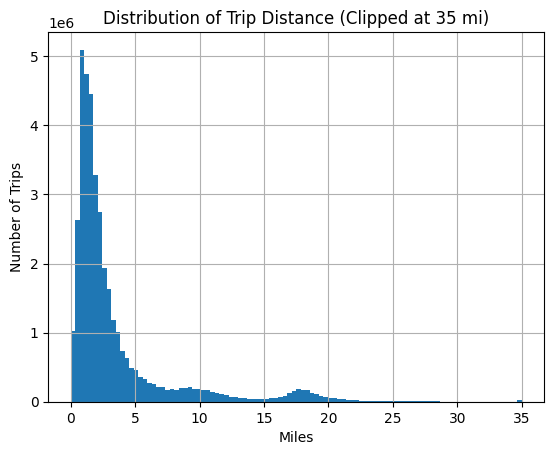

In [16]:
import matplotlib.pyplot as plt

df_cleaned["trip_distance"].clip(upper=35).hist(bins=100)  # clipping at 35 miles for readability
plt.title("Distribution of Trip Distance (Clipped at 35 mi)")
plt.xlabel("Miles")
plt.ylabel("Number of Trips")
plt.show()


In [17]:
# check how many entries are from different years in 'tpep_pickup_datetime' column
print(df_cleaned['tpep_pickup_datetime'].dt.year.value_counts())

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


tpep_pickup_datetime
2022    38287234
2002         441
2009          40
2008          34
2021          24
2003           9
2001           6
2023           6
2012           1
Name: count, dtype: int64


In [10]:
# only keep the rows from 2022
df_cleaned = df_cleaned[df_cleaned['tpep_pickup_datetime'].dt.year == 2022]

In [11]:
# make a copy of the dataframe but limit trip distance to 35 miles
df_cleaned_35 = df_cleaned.copy()
# remove rows where trip distance is greater than 35 miles
df_cleaned_35 = df_cleaned_35[df_cleaned_35["trip_distance"] <= 35]

In [20]:
# what is the percentage of data in df_cleaned_35 compared to df_cleaned?
percentage = (len(df_cleaned_35) / len(df_cleaned)) * 100
print(f"Percentage of data in df_cleaned_35 compared to df_cleaned: {percentage:.2f}%")

Percentage of data in df_cleaned_35 compared to df_cleaned: 99.95%


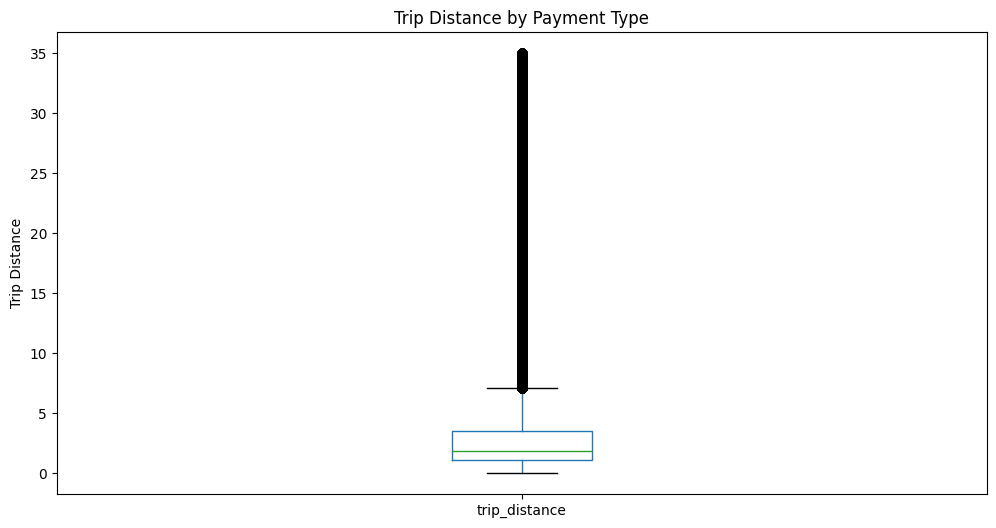

In [21]:
# create box and whisker plot for the fare trip_distance
df_cleaned_35.boxplot(column='trip_distance',  figsize=(12, 6), grid=False)
import matplotlib.pyplot as plt
plt.suptitle('')
plt.title('Trip Distance by Payment Type')
plt.ylabel('Trip Distance')
plt.show()

In [22]:
df_cleaned_35[df_cleaned_35["trip_distance"] > 0] \
    .sort_values(by=["trip_distance", "total_amount"], ascending=[False, False]) \
    .head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,airport_fee
11972490,1,2022-05-26 13:47:08,2022-05-26 15:12:29,1.0,35.0,5.0,48,265,1,253.0,0.00,0.0,50.65,0.00,303.95,0.0,0.00
18471380,2,2022-06-20 01:10:12,2022-06-20 01:58:56,2.0,35.0,5.0,132,265,1,189.0,0.00,0.0,39.17,6.55,236.27,0.0,1.25
36024366,2,2022-11-30 01:08:22,2022-11-30 01:54:41,1.0,35.0,5.0,100,265,1,175.0,0.00,0.0,46.09,6.55,230.44,2.5,0.00
10048916,1,2022-05-09 21:30:05,2022-05-09 22:14:23,1.0,35.0,5.0,132,265,1,220.0,1.25,0.0,0.00,6.55,228.10,0.0,1.25
18546573,1,2022-06-20 19:59:43,2022-06-20 20:46:28,4.0,35.0,5.0,132,265,1,195.0,1.25,0.0,10.00,6.55,213.10,0.0,1.25
19129268,1,2022-06-25 18:04:44,2022-06-25 19:21:53,0.0,35.0,5.0,10,1,1,180.0,0.00,0.0,0.00,20.30,200.60,0.0,0.00
33341325,1,2022-11-03 20:49:17,2022-11-03 21:33:23,1.0,35.0,4.0,132,265,1,164.0,1.75,0.5,33.30,0.00,199.85,0.0,1.25
17434840,1,2022-06-10 22:02:08,2022-06-10 23:01:01,1.0,35.0,4.0,162,265,1,145.0,3.00,0.5,45.45,2.75,197.00,2.5,0.00
1129748,1,2022-01-16 09:16:02,2022-01-16 09:59:05,1.0,35.0,5.0,132,265,2,175.0,1.25,0.0,0.00,18.30,194.85,0.0,1.25
10135882,1,2022-05-10 18:24:17,2022-05-10 19:31:52,2.0,35.0,5.0,132,265,1,162.5,1.25,0.0,10.00,20.30,194.35,0.0,1.25


In [30]:
# what is the max fare amount?
print(df_cleaned_35["total_amount"].max())

401095.62


In [12]:
# remove rows where total amount is greater than 100 or less than 0
df_cleaned_35 = df_cleaned_35[(df_cleaned_35["total_amount"] <= 100) & (df_cleaned_35["total_amount"] >= 0)]

NameError: name 'plt' is not defined

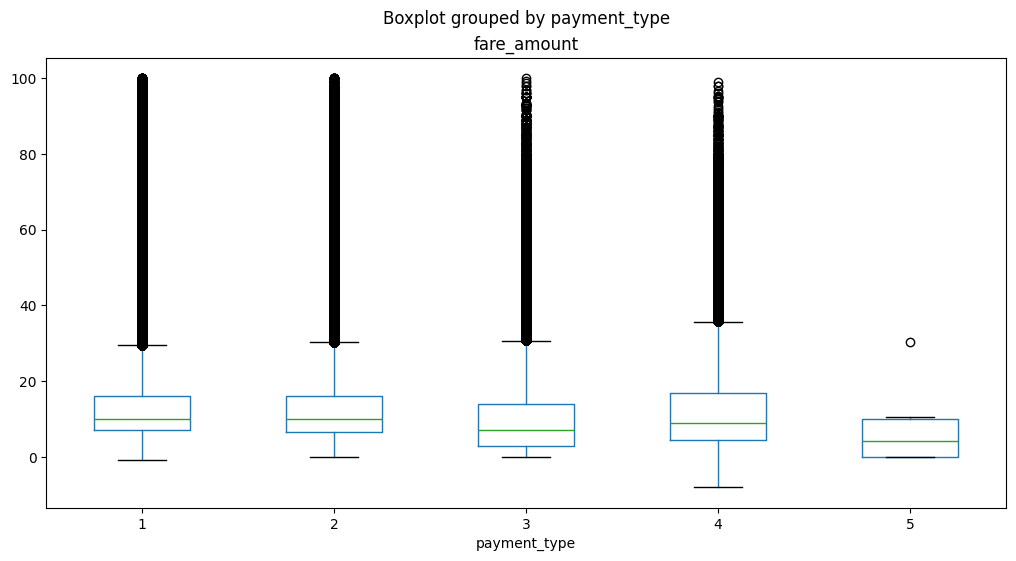

In [13]:
# create box and whisker plot for the fare amount
df_cleaned_35.boxplot(column='fare_amount', by='payment_type', figsize=(12, 6), grid=False)
plt.suptitle('')
plt.title('Fare Amount by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Fare Amount')
plt.show()

In [14]:
#  create a new column that calculates time difference between pickup and dropoff datetime, resulting in a timedelta object
df_cleaned_35['trip_duration'] = df_cleaned_35['tpep_dropoff_datetime'] - df_cleaned_35['tpep_pickup_datetime']
# convert the timedelta object to minutes
df_cleaned_35['trip_duration'] = df_cleaned_35['trip_duration'].dt.total_seconds() / 60.0
# make new column 'average_speed' that calculates average speed in miles per hour
df_cleaned_35['average_speed'] = df_cleaned_35['trip_distance'] / (df_cleaned_35['trip_duration'] / 60.0)

In [15]:
# import taxi_zone_lookup.csv file
zone_lookup = mpd.read_csv(r"taxi_zone_lookup.csv")
# check the first 5 rows of the dataframe
print(zone_lookup.head())

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


In [16]:
# Merging
# Rename Zone column so it's clear after merge
zone_lookup_pickup = zone_lookup.rename(columns={
    "LocationID": "PULocationID",
    "Zone": "pickup_zone"
})

zone_lookup_dropoff = zone_lookup.rename(columns={
    "LocationID": "DOLocationID",
    "Zone": "dropoff_zone"
})

# Merge pickup zone
df_cleaned_35 = df_cleaned_35.merge(zone_lookup_pickup[["PULocationID", "pickup_zone"]],
                                    on="PULocationID", how="left")

# Merge dropoff zone
df_cleaned_35 = df_cleaned_35.merge(zone_lookup_dropoff[["DOLocationID", "dropoff_zone"]],
                                    on="DOLocationID", how="left")

In [ ]:
df_cleaned_35.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_zone,dropoff_zone
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2,3.80,1,142,236,1,14.5,...,0.5,3.65,0.00,21.95,2.5,0.0,17.816667,12.797007,Lincoln Square East,Upper East Side North
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1,2.10,1,236,42,1,8.0,...,0.5,4.00,0.00,13.30,0.0,0.0,8.400000,15.000000,Upper East Side North,Central Harlem North
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1,0.97,1,166,166,1,7.5,...,0.5,1.76,0.00,10.56,0.0,0.0,8.966667,6.490706,Morningside Heights,Morningside Heights
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1,1.09,1,114,68,2,8.0,...,0.5,0.00,0.00,11.80,2.5,0.0,10.033333,6.518272,Greenwich Village South,East Chelsea
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1,4.30,1,68,163,1,23.5,...,0.5,3.00,0.00,30.30,2.5,0.0,37.533333,6.873890,East Chelsea,Midtown North
5,1,2022-01-01 00:40:15,2022-01-01 01:09:48,1,10.30,1,138,161,1,33.0,...,0.5,13.00,6.55,56.35,2.5,0.0,29.550000,20.913706,LaGuardia Airport,Midtown Center
6,2,2022-01-01 00:20:50,2022-01-01 00:34:58,1,5.07,1,233,87,1,17.0,...,0.5,5.20,0.00,26.00,2.5,0.0,14.133333,21.523585,UN/Turtle Bay South,Financial District North
7,2,2022-01-01 00:13:04,2022-01-01 00:22:45,1,2.02,1,238,152,2,9.0,...,0.5,0.00,0.00,12.80,2.5,0.0,9.683333,12.516351,Upper West Side North,Manhattanville
8,2,2022-01-01 00:30:02,2022-01-01 00:44:49,1,2.71,1,166,236,1,12.0,...,0.5,2.25,0.00,18.05,2.5,0.0,14.783333,10.998873,Morningside Heights,Upper East Side North
9,2,2022-01-01 00:48:52,2022-01-01 00:53:28,1,0.78,1,236,141,2,5.0,...,0.5,0.00,0.00,8.80,2.5,0.0,4.600000,10.173913,Upper East Side North,Lenox Hill West


In [42]:
# print number of rows where average speed is greater than 80 mph
print(len(df_cleaned_35[df_cleaned_35["average_speed"] > 80]))

35363


In [17]:
# sort the dataframe by average speed in descending order
#df_cleaned_35[df_cleaned_35["average_speed"] > 80].sort_values("average_speed", ascending=False).head(10)
# as we can see there is an issue with some pickup and dropoff times
# we will drop the rows where average speed is greater than 80 mph
df_cleaned_35 = df_cleaned_35[df_cleaned_35["average_speed"] <= 80]

In [ ]:
df_cleaned_35.sort_values("average_speed", ascending=False).head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_zone,dropoff_zone
12923442,1,2022-04-06 22:46:51,2022-04-06 22:47:00,3.0,0.2,5.0,234,234,1,20.0,...,0.0,2.00,0.0,22.30,0.0,0.00,0.15,80.0,Union Sq,Union Sq
83035,1,2022-01-02 13:44:00,2022-01-02 13:44:18,1.0,0.4,3.0,132,132,1,20.0,...,0.0,38.45,0.0,60.00,0.0,1.25,0.30,80.0,JFK Airport,JFK Airport
2240412,1,2022-01-29 23:42:25,2022-01-29 23:43:10,0.0,1.0,1.0,48,48,3,2.5,...,0.5,0.00,0.0,6.30,2.5,0.00,0.75,80.0,Clinton East,Clinton East
28168522,1,2022-09-29 18:02:14,2022-09-29 18:02:23,1.0,0.2,1.0,140,140,3,2.5,...,0.5,0.00,0.0,6.80,2.5,0.00,0.15,80.0,Lenox Hill East,Lenox Hill East
13690928,1,2022-04-13 15:21:51,2022-04-13 15:22:09,0.0,0.4,1.0,161,161,2,2.5,...,0.5,0.00,0.0,5.80,2.5,0.00,0.30,80.0,Midtown Center,Midtown Center
18647306,1,2022-06-26 12:32:33,2022-06-26 12:32:42,0.0,0.2,5.0,264,264,1,50.0,...,0.0,0.00,0.0,50.30,0.0,0.00,0.15,80.0,NaN,NaN
27049942,1,2022-09-19 10:43:30,2022-09-19 10:44:06,1.0,0.8,1.0,161,161,2,2.5,...,0.5,0.00,0.0,5.80,2.5,0.00,0.60,80.0,Midtown Center,Midtown Center
11242524,1,2022-05-22 14:48:46,2022-05-22 14:48:55,3.0,0.2,5.0,132,132,1,100.0,...,0.0,0.00,0.0,101.55,0.0,1.25,0.15,80.0,JFK Airport,JFK Airport
6236768,1,2022-03-09 17:48:29,2022-03-09 17:48:47,1.0,0.4,3.0,42,42,4,20.0,...,0.0,0.00,0.0,21.30,0.0,0.00,0.30,80.0,Central Harlem North,Central Harlem North
37043754,1,2022-12-18 05:15:37,2022-12-18 05:15:55,1.0,0.4,1.0,50,50,3,2.5,...,0.5,0.00,0.0,6.30,2.5,0.00,0.30,80.0,Clinton West,Clinton West


In [18]:
# how much percentage wise of data left compared to the original dataframe
percentage = (len(df_cleaned_35) / len(df)) * 100
print(f"Percentage of data in df_cleaned_35 compared to df_cleaned: {percentage:.2f}%")

Percentage of data in df_cleaned_35 compared to df_cleaned: 95.42%


In [19]:
# if pickup and dropoff zones  are equal to 'NaN' replace with 'Outside NYC'
df_cleaned_35['pickup_zone'] = df_cleaned_35['pickup_zone'].fillna('Outside NYC')
df_cleaned_35['dropoff_zone'] = df_cleaned_35['dropoff_zone'].fillna('Outside NYC')
# check unique values in pickup and dropoff zones



In [47]:
print(len(df_cleaned_35['pickup_zone'].unique()))
print(len(df_cleaned_35['dropoff_zone'].unique()))

261
261


In [20]:
# drop any rows where pickup and dropoff zones are equal 'Outside NYC'
df_cleaned_35 = df_cleaned_35[~((df_cleaned_35['pickup_zone'] == 'Outside NYC') & (df_cleaned_35['dropoff_zone'] == 'Outside NYC'))]

In [48]:
# how many different combinations of pickup and dropoff zones are there?
print(len(df_cleaned_35[['pickup_zone', 'dropoff_zone']].drop_duplicates()))

42280


In [21]:
# Extract hour of day and day of week from pickup timestamp
df_cleaned_35["hour_of_day"] = df_cleaned_35["tpep_pickup_datetime"].dt.hour
df_cleaned_35["day_of_week"] = df_cleaned_35["tpep_pickup_datetime"].dt.dayofweek  # Monday = 0

In [22]:
def is_peak(hour, speed):
    if hour in [6, 7, 8, 9, 16, 17, 18, 17] and speed < 10:
        return 1
    return 0

df_cleaned_35["is_rush_hour"] = df_cleaned_35.apply(lambda row: is_peak(row["hour_of_day"], row["average_speed"]), axis=1)


In [25]:
# only leave columns in df_cleaned_35 where trip_duration is greater or equal to 1 and less than or equal to 90
df_cleaned_35 = df_cleaned_35[(df_cleaned_35["trip_duration"] >= 1) & (df_cleaned_35["trip_duration"] <= 90)]

In [34]:
percentage = (len(df_cleaned_35) / len(df)) * 100
print(f"Percentage of data in df_cleaned_35 compared to df_cleaned: {percentage:.2f}%")

Percentage of data in df_cleaned_35 compared to df_cleaned: 93.78%


In [36]:
# Make a copy to preserve original
df_model_ready = df_cleaned_35.copy()

# Drop all unnecessary columns
df_model_ready = df_model_ready[[
    "pickup_zone", "dropoff_zone",
    "hour_of_day", "day_of_week",
    "passenger_count", "trip_distance",
    "RatecodeID", "congestion_surcharge",
    "average_speed", "is_rush_hour",
    "trip_duration", "total_amount", "average_speed"   
]]


In [40]:
from sklearn.preprocessing import LabelEncoder
le_pickup = LabelEncoder()
le_dropoff = LabelEncoder()

df_cleaned_35["pickup_zone_enc"] = le_pickup.fit_transform(df_cleaned_35["pickup_zone"])
df_cleaned_35["dropoff_zone_enc"] = le_dropoff.fit_transform(df_cleaned_35["dropoff_zone"])
# Step 1: Sample the dataset (1 million rows)
df_sample_filtered = df_model_ready.sample(n=1_000_000, random_state=42)


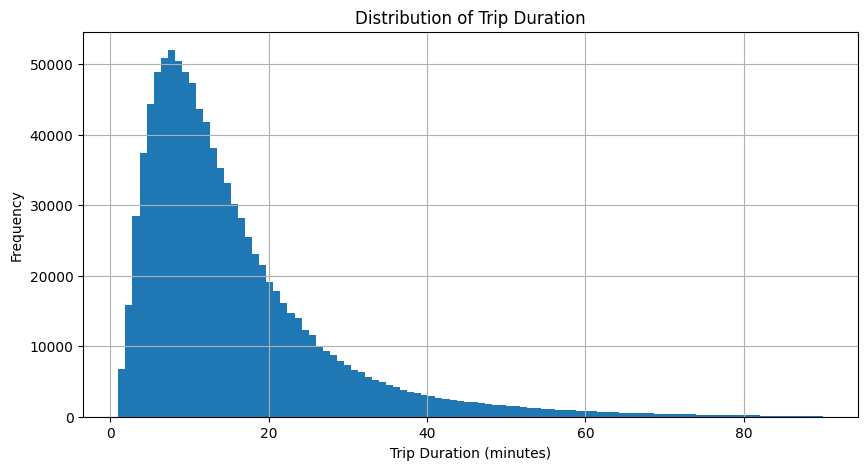

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
df_sample_filtered["trip_duration"].hist(bins=100)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Trip Duration")
plt.grid(True)
plt.show()

## Chain model

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import joblib

df_sample_filtered["pickup_zone_enc"] = le_pickup.transform(df_sample_filtered["pickup_zone"])
df_sample_filtered["dropoff_zone_enc"] = le_dropoff.transform(df_sample_filtered["dropoff_zone"])

# Define base features
base_features = [
    "pickup_zone_enc", "dropoff_zone_enc",
    "RatecodeID", "hour_of_day", "day_of_week", "is_rush_hour"
]

# === 3. Train Distance Model ===
distance_features = base_features
X_dist = df_sample_filtered[distance_features]
y_dist = df_sample_filtered["trip_distance"]

X_train_dist, X_test_dist, y_train_dist, y_test_dist = train_test_split(X_dist, y_dist, test_size=0.2, random_state=42)

distance_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
distance_model.fit(X_train_dist, y_train_dist)

y_pred_dist = distance_model.predict(X_test_dist)
rmse_dist = np.sqrt(mean_squared_error(y_test_dist, y_pred_dist))
print(f"Distance Model RMSE: {rmse_dist:.2f} miles")

# Predict distances for all rows
df_sample_filtered["predicted_distance"] = distance_model.predict(X_dist)

# === 4. Train Duration Model ===
duration_features = base_features + ["predicted_distance"]
X_dur = df_sample_filtered[duration_features]
y_dur = np.log1p(df_sample_filtered["trip_duration"])  # log-transform duration

X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(X_dur, y_dur, test_size=0.2, random_state=42)

duration_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
duration_model.fit(X_train_dur, y_train_dur)

y_pred_dur_log = duration_model.predict(X_test_dur)
y_pred_dur = np.expm1(y_pred_dur_log)
y_true_dur = np.expm1(y_test_dur)

rmse_dur = np.sqrt(mean_squared_error(y_true_dur, y_pred_dur))
print(f"Duration Model RMSE: {rmse_dur:.2f} minutes")

# Predict durations for all rows
df_sample_filtered["predicted_duration"] = np.expm1(duration_model.predict(X_dur))

# === 5. Train Fare Model ===
fare_features = base_features + ["predicted_distance", "predicted_duration"]
X_fare = df_sample_filtered[fare_features]
y_fare = df_sample_filtered["total_amount"]

X_train_fare, X_test_fare, y_train_fare, y_test_fare = train_test_split(X_fare, y_fare, test_size=0.2, random_state=42)

fare_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
fare_model.fit(X_train_fare, y_train_fare)

y_pred_fare = fare_model.predict(X_test_fare)
rmse_fare = np.sqrt(mean_squared_error(y_test_fare, y_pred_fare))
print(f"Fare Model RMSE: {rmse_fare:.2f} dollars")

# === 6. Save models and encoders ===
joblib.dump(distance_model, "trip_distance_model.pkl")
joblib.dump(duration_model, "trip_duration_model.pkl")
joblib.dump(fare_model, "trip_fare_model.pkl")
joblib.dump(le_pickup, "pickup_zone_encoder.pkl")
joblib.dump(le_dropoff, "dropoff_zone_encoder.pkl")


Distance Model RMSE: 1.41 miles


Duration Model RMSE: 6.22 minutes
Fare Model RMSE: 5.37 dollars


['dropoff_zone_encoder.pkl']

In [ ]:
# Old model code
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import joblib

# # Step 1: Label encode zones
# le_pickup = LabelEncoder()
# le_dropoff = LabelEncoder()

# df_sample_filtered["pickup_zone_enc"] = le_pickup.fit_transform(df_sample_filtered["pickup_zone"])
# df_sample_filtered["dropoff_zone_enc"] = le_dropoff.fit_transform(df_sample_filtered["dropoff_zone"])

# # Step 2: Feature matrix & target (log-transformed)
# features = [
#     "pickup_zone_enc", "dropoff_zone_enc",
#     "hour_of_day", "day_of_week",
#     "passenger_count", "trip_distance",
#     "RatecodeID", "congestion_surcharge",
#     "average_speed", "is_rush_hour"
# ]

# X = df_sample_filtered[features]
# y = np.log1p(df_sample_filtered["trip_duration"])  # log1p = log(1 + x)

# # Step 3: Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 4: Train model
# model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)

# # Step 5: Predict and reverse log-transform
# y_pred_log = model.predict(X_test)
# y_pred = np.expm1(y_pred_log)  # reverse log1p
# y_test_actual = np.expm1(y_test)

# # Step 6: Evaluate
# mae = mean_absolute_error(y_test_actual, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# print(f"MAE: {mae:.2f} minutes")
# print(f"RMSE: {rmse:.2f} minutes")

# # Step 7: Save model and encoders
# joblib.dump(model, "trip_duration_model.pkl")
# joblib.dump(le_pickup, "pickup_zone_encoder.pkl")
# joblib.dump(le_dropoff, "dropoff_zone_encoder.pkl")


MAE: 0.06 minutes
RMSE: 0.95 minutes


['dropoff_zone_encoder.pkl']

In [ ]:
# Old code for streamlit app
# import streamlit as st
# import joblib
# import numpy as np

# # Load model and encoders
# model = joblib.load("trip_duration_model.pkl")
# le_pickup = joblib.load("pickup_zone_encoder.pkl")
# le_dropoff = joblib.load("dropoff_zone_encoder.pkl")

# # Get list of original zone names
# pickup_zones = le_pickup.classes_.tolist()
# dropoff_zones = le_dropoff.classes_.tolist()

# st.title("NYC Taxi Trip Duration Predictor")
# st.markdown("Estimate how long a taxi ride will take based on pickup/dropoff zones, time, and more.")

# # --- Sidebar Inputs ---
# st.sidebar.header("Input Trip Details")
# pickup_zone = st.sidebar.selectbox("Pickup Zone", pickup_zones)
# dropoff_zone = st.sidebar.selectbox("Dropoff Zone", dropoff_zones)
# hour_of_day = st.sidebar.slider("Hour of Day", 0, 23, 8)
# day_of_week = st.sidebar.selectbox("Day of Week (0=Mon, 6=Sun)", list(range(7)))
# passenger_count = st.sidebar.slider("Passenger Count", 1, 6, 1)
# trip_distance = st.sidebar.slider("Trip Distance (miles)", 0.1, 25.0, 2.5, step=0.1)
# rate_code = st.sidebar.selectbox("Rate Code ID", [1, 2, 3, 4, 5, 6])
# congestion = st.sidebar.selectbox("Congestion Surcharge", [0.0, 2.5])
# avg_speed = st.sidebar.slider("Estimated Average Speed (mph)", 1.0, 40.0, 10.0)

# # --- Feature Engineering ---
# pickup_enc = le_pickup.transform([pickup_zone])[0]
# dropoff_enc = le_dropoff.transform([dropoff_zone])[0]
# is_rush_hour = 1 if hour_of_day in [7, 8, 9, 16, 17, 18] and avg_speed < 10 else 0

# X_input = np.array([[pickup_enc, dropoff_enc, hour_of_day, day_of_week,
#                      passenger_count, trip_distance, rate_code,
#                      congestion, avg_speed, is_rush_hour]])

# # --- Prediction ---
# log_duration_pred = model.predict(X_input)[0]
# duration_pred = np.expm1(log_duration_pred)  # Reverse log1p

# st.subheader("Predicted Trip Duration")
# st.write(f"🚕 Estimated Duration: **{duration_pred:.2f} minutes**")


2025-04-25 13:13:13.556 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 13:13:13.759 
  command:

    streamlit run c:\Users\Asus\Desktop\Spring 2025\Data Ethics\Data2\Yellow_Taxi\modin-env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-25 13:13:13.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 13:13:13.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 13:13:13.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 13:13:13.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 13:13:13.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode

In [34]:
code = '''
import streamlit as st
import joblib
import numpy as np

# Load model and encoders
model = joblib.load("trip_duration_model.pkl")
le_pickup = joblib.load("pickup_zone_encoder.pkl")
le_dropoff = joblib.load("dropoff_zone_encoder.pkl")

# Get list of original zone names
pickup_zones = le_pickup.classes_.tolist()
dropoff_zones = le_dropoff.classes_.tolist()

st.title("NYC Taxi Trip Duration Predictor")
st.markdown("Estimate how long a taxi ride will take based on pickup/dropoff zones, time, and more.")

# --- Sidebar Inputs ---
st.sidebar.header("Input Trip Details")
pickup_zone = st.sidebar.selectbox("Pickup Zone", pickup_zones)
dropoff_zone = st.sidebar.selectbox("Dropoff Zone", dropoff_zones)
hour_of_day = st.sidebar.slider("Hour of Day", 0, 23, 8)
day_of_week = st.sidebar.selectbox("Day of Week (0=Mon, 6=Sun)", list(range(7)))
passenger_count = st.sidebar.slider("Passenger Count", 1, 6, 1)
trip_distance = st.sidebar.slider("Trip Distance (miles)", 0.1, 25.0, 2.5, step=0.1)
rate_code = st.sidebar.selectbox("Rate Code ID", [1, 2, 3, 4, 5, 6])
congestion = st.sidebar.selectbox("Congestion Surcharge", [0.0, 2.5])
avg_speed = st.sidebar.slider("Estimated Average Speed (mph)", 1.0, 40.0, 10.0)

# --- Feature Engineering ---
pickup_enc = le_pickup.transform([pickup_zone])[0]
dropoff_enc = le_dropoff.transform([dropoff_zone])[0]
is_rush_hour = 1 if hour_of_day in [7, 8, 9, 16, 17, 18] and avg_speed < 10 else 0

X_input = np.array([[pickup_enc, dropoff_enc, hour_of_day, day_of_week,
                     passenger_count, trip_distance, rate_code,
                     congestion, avg_speed, is_rush_hour]])

# --- Prediction ---
log_duration_pred = model.predict(X_input)[0]
duration_pred = np.expm1(log_duration_pred)  # Reverse log1p

st.subheader("Predicted Trip Duration")
st.write(f"🚕 Estimated Duration: **{duration_pred:.2f} minutes**")
'''

with open("trip_duration_dashboard.py", "w", encoding="utf-8") as f:
    f.write(code)
